# (simple) GMM Clustering Implementing

In [15]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans # for comparison

import scipy as sp

Make some simulated data:

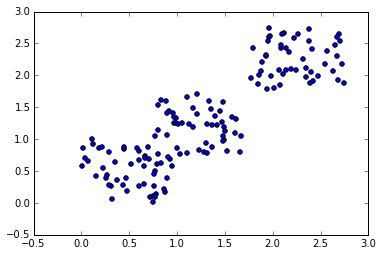

In [17]:
# Make some simple data on the unit square
def MakeUnifData(N):
    XX = np.random.rand(N, 2)
    return(XX)

X = np.vstack((MakeUnifData(50), MakeUnifData(50) + 0.75, MakeUnifData(50) + 1.75))
#X = MakeUnifData(50)
plt.scatter(X[:, 0], X[:, 1])

Let's implement a simple GMM, which has the following steps:

1. Pick some starting parameters (cluster centers [means], and variances)

2. Iterate until convergence: 

a. calculate the P(data point i assigned to cluster j | parameters) 

b. estimate parameters based on values calculated in (a)

Remember: why do we need to do this? This is because we cannot solve the problem directly without knowing what points are in what cluster. So, we can approach this by first guessing the assignments and then doing the problem, and then making a more educated guess of the assignments based on the parameters.

In [7]:
def pdf_multivariate_gauss(x, mu, cov):
    '''
    Caculate the multivariate normal density (pdf)

    Keyword arguments:
        x = numpy array of a "d x 1" sample vector
        mu = numpy array of a "d x 1" mean vector
        cov = "numpy array of a d x d" covariance matrix
    '''
    assert(mu.shape[0] >= mu.shape[1]), 'mu must be a column vector'
    assert(x.shape[0] >= x.shape[1]), 'x must be a column vector'
    assert(cov.shape[0] == cov.shape[1]), 'covariance matrix must be square'
    assert(mu.shape[0] == cov.shape[0]), 'cov_mat and mu_vec must have the same dimensions'
    assert(mu.shape[0] == x.shape[0]), 'mu and x must have the same dimensions'
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

def RandomInit(XX, NC):
    # means and variances
    d = XX.shape[1]
    selections = np.random.choice(XX.shape[0], NC, replace=False)
    meanv = np.array([np.array([X[i, :]]).transpose() for i in selections])
    varv = np.array([np.array([[1., 0.], [0., 1.]]) for ii in range(NC)])
    
    return meanv, varv

# E step

def PAssignToClusters(xx, meanv, varv, alphas, NC):
    raw_probs = np.array([pdf_multivariate_gauss(np.array([xx]).transpose(), 
                                                 meanv[ii, :, :], varv[ii, :, :]) for ii in range(NC)])
    norm_probs = raw_probs * alphas / (raw_probs * alphas).sum()
    
    return norm_probs

def PAssignDataToClusters(XX, meanv, varv, alphas, NC):
    return np.array([PAssignToClusters(XX[ii, :], meanv, varv, alphas, NC) for ii in range(XX.shape[0])])

# hard assignment
def AssignToClusters(norm_probs):
    ap = np.array([np.where(norm_probs[ii, :] == np.max(norm_probs[ii, :])) for ii in range(norm_probs.shape[0])])
    return ap.flatten().flatten()

# M step

def EstimateAlphas(assignp):
    # note that we do not need to divide by N, as this will cancel in the
    # only place we actually need alpha (which is in the p_assign calculation)
    return np.sum(assignp, 0)

def EstimateMean(XX, assignp, alphas, kk, NC):
    wp = np.array([XX[ii, :] * assignp[ii, kk] / (alphas[kk]) for ii in range(XX.shape[0])])
    wp = np.sum(wp, 0)
    wp = np.array([wp]).transpose()
    return wp

def EstimateMeans(XX, assignp, alphas, NC):
    return np.array([EstimateMean(XX, assignp, alphas, kk, NC) for kk in range(NC)])

def EstimateVar(XX, assignp, alphas, means, kk):
    mm = means[kk, :, :].flatten()
    vp = np.array([np.outer(XX[ii, :] - mm, XX[ii, :] - mm) * assignp[ii, kk] / alphas[kk] for ii in range(XX.shape[0])])
    return np.sum(vp, 0)

def EstimateVars(XX, assignp, alphas, means, NC):
    return np.array([EstimateVar(XX, assignp, alphas, means, kk) for kk in range(NC)])

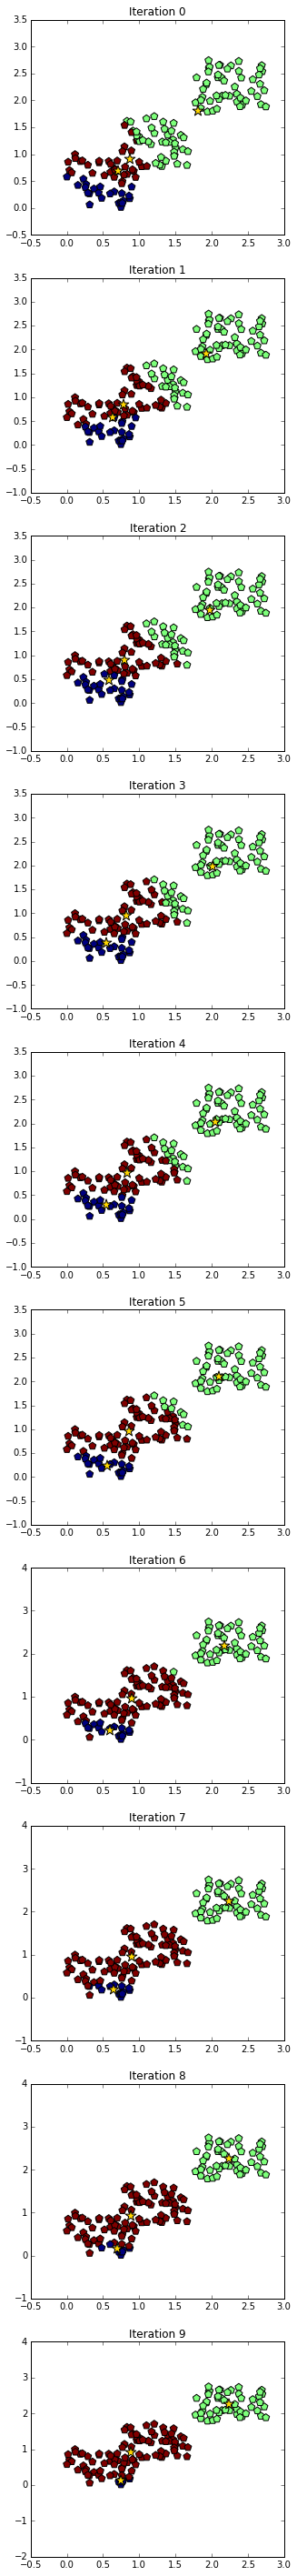

In [18]:
nc = 3

niter = 10

mv, vv = RandomInit(X, nc)
alphas = [1 / (nc * 1.0) for i in range(nc)]

f, axarr = plt.subplots(niter)

for jj in range(niter): 
    # E step
    assignp = PAssignDataToClusters(X, mv, vv, alphas, nc)
    
    # M step
    alphas = EstimateAlphas(assignp)
    mv = EstimateMeans(X, assignp, alphas, nc)
    vv = EstimateVars(X, assignp, alphas, mv, nc)
    
    # 'hard' assignment
    ha = AssignToClusters(assignp)
    
    axarr[jj].scatter(X[:, 0], X[:, 1], c=ha, s=70, marker=(5, 0))
    axarr[jj].scatter(mv[:, 0, :], mv[:, 1, :], c='gold', s=150, marker='*')
    axarr[jj].set_title('Iteration ' + str(jj))
    
f.set_figheight(5 * niter)
f.set_figwidth(5)